<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/17_gpt2_next_token_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPT-2 next token prediction

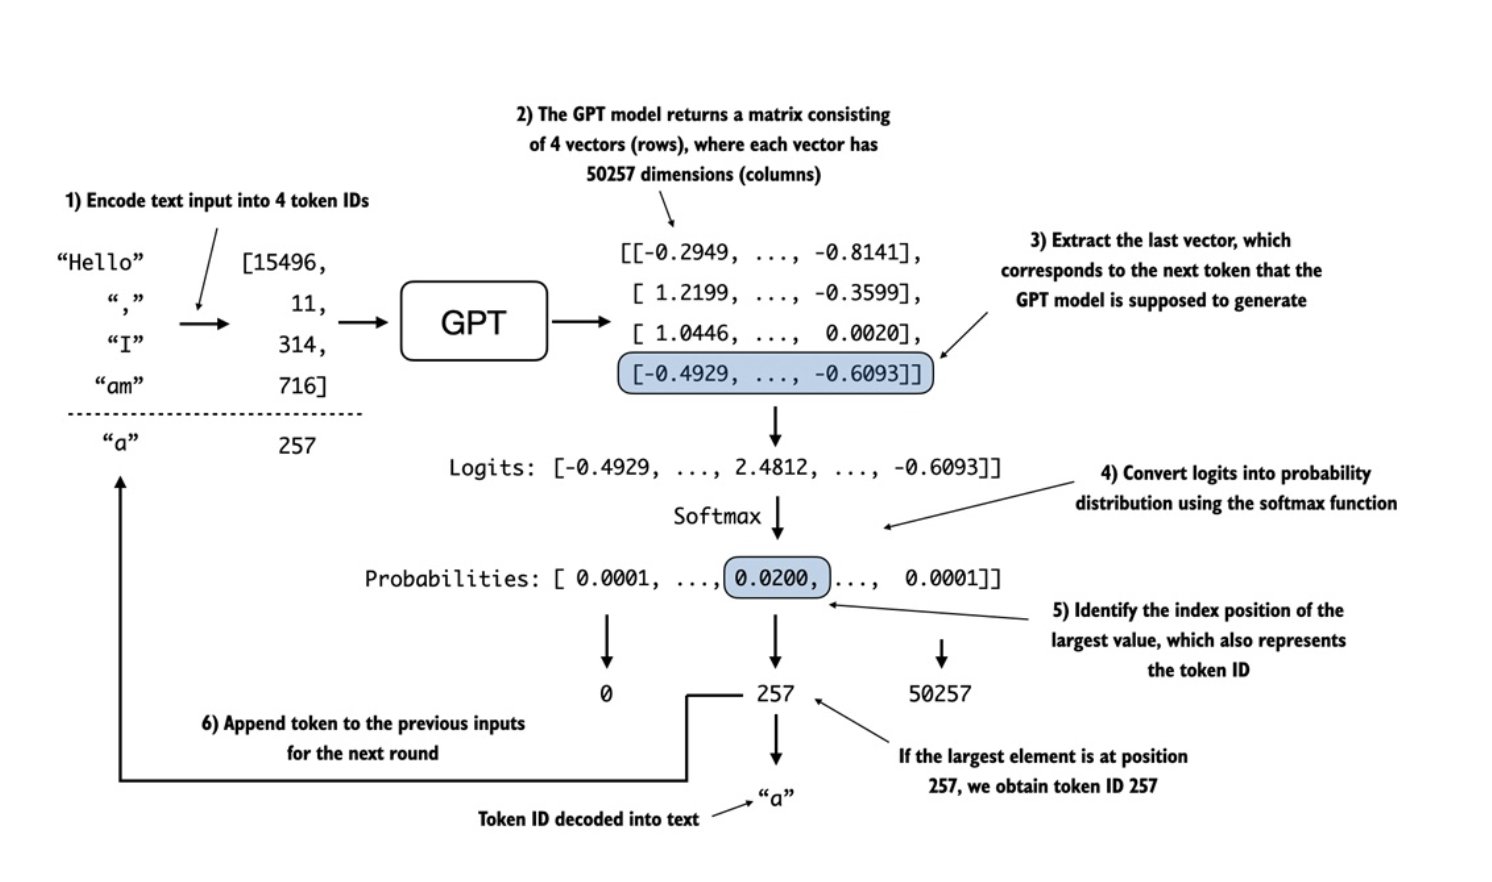

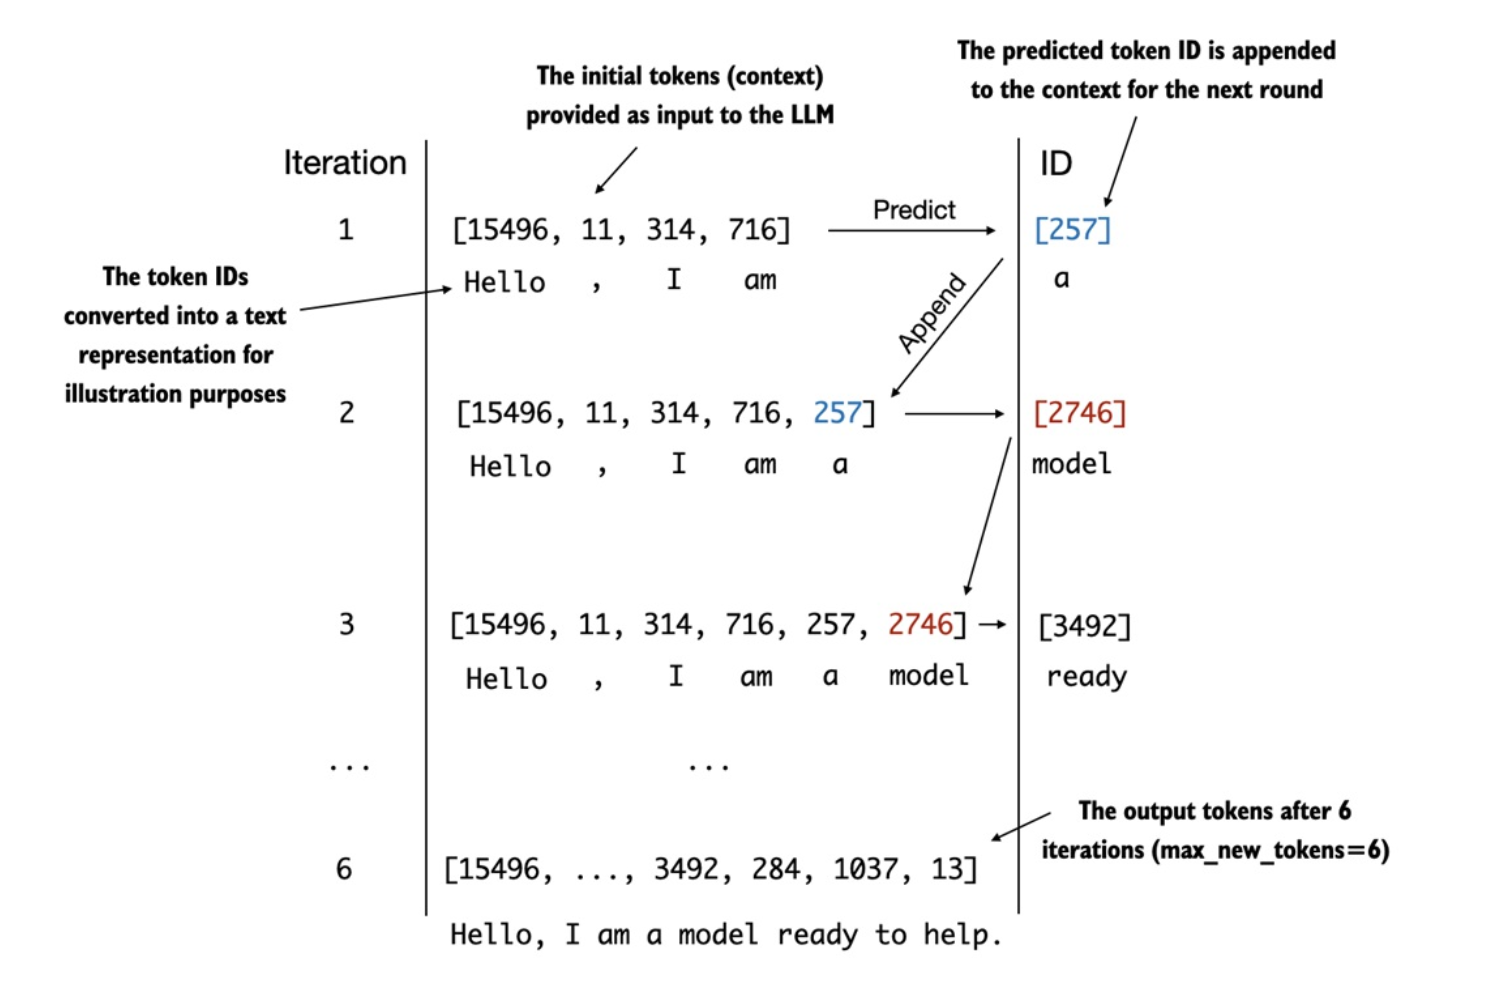

In [ ]:
import torch
import torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers   (number of tranformer blocks)
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
  def __init__(self) -> None:
    super().__init__()

  def forward(self, x):
    # approx GeLu function
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec



class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        print("token embedding shape: ", tok_embeds.shape)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        print("position embedding shape: " ,pos_embeds.shape)
        x = tok_embeds + pos_embeds

        # dropout helps in generalization and avoid overfitting
        x = self.drop_emb(x)
        x = self.trf_blocks(x)

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



##  `max_new_tokens` — Meaning

`max_new_tokens` = **the number of tokens you want the model to generate beyond the current input context.**

It tells the loop **how many new tokens** to predict **step by step** (autoregressively).

---

### 🧩 Example

Suppose your current input (`idx`) is:

```python
idx = [[50256, 1212, 318]]   # tokens for "<BOS> I love"
```

and you call:

```python
generate_text_simple(model, idx, max_new_tokens=5, context_size=10)
```

Then the function will:

1. Take your current context: `"<BOS> I love"`
2. Predict the **next token** (say `"machine"`)
3. Append it → `"<BOS> I love machine"`
4. Repeat again to predict the next one (`"learning"`)
5. Continue this **5 times total**

✅ After the loop, you’ll have **5 newly generated tokens** appended to your original context.

---

### 📘 So conceptually:

| Parameter        | Meaning                                                             |
| ---------------- | ------------------------------------------------------------------- |
| `max_new_tokens` | How many tokens to generate in total                                |
| `context_size`   | How many *previous tokens* the model can see (model’s window limit) |
| `idx`            | Your starting sequence (prompt/context)                             |

---

In [27]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  # idx is (batch, n_tokens) array of indices in the current context

  for _ in range(max_new_tokens):
      # Crop current context if it exceeds the supported context size
      # E.g., if LLM supports only 5 tokens, and the context size is 10
      # then only the last 5 tokens are used as context
      idx_cond = idx[:, -context_size:]

      # Get the predictions
      with torch.no_grad():
          logits = model(idx_cond)
      # logits dimesion will be (batch, num_tokens, vocab_size)


      # Focus only on the last time step
      # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
      logits = logits[:, -1, :]

      # Apply softmax to get probabilities
      probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

      # Get the idx of the vocab entry with the highest probability value
      idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

      # Append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

  return idx

In the preceeding code, the generate_text_simple function, we use a softmax function to convert the logits into a probability distribution from which we identify the position with the
highest value via torch.argmax.

The softmax function is monotonic, meaning it preserves
the order of its inputs when transformed into outputs.

So, in practice, the softmax step is
redundant since the position with the highest score in the softmax output tensor is the same position in the logit tensor.

In other words, we could apply the torch.argmax function
to the logits tensor directly and get identical results.

However, we coded the conversion to illustrate the full process of transforming logits to probabilities, which can add additional intuition, such as that the model generates the most likely next token, which is known as greedy decoding.


In [28]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Next, we put the model into .eval() mode, which disables random components like dropout, which are only used during training, and use the generate_text_simple function on the encoded input tensor:

In [30]:
model = GPTModel(GPT_CONFIG_124M)
model.eval()

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

token embedding shape:  torch.Size([1, 4, 768])
position embedding shape:  torch.Size([4, 768])
token embedding shape:  torch.Size([1, 5, 768])
position embedding shape:  torch.Size([5, 768])
token embedding shape:  torch.Size([1, 6, 768])
position embedding shape:  torch.Size([6, 768])
token embedding shape:  torch.Size([1, 7, 768])
position embedding shape:  torch.Size([7, 768])
token embedding shape:  torch.Size([1, 8, 768])
position embedding shape:  torch.Size([8, 768])
token embedding shape:  torch.Size([1, 9, 768])
position embedding shape:  torch.Size([9, 768])
Output: tensor([[15496,    11,   314,   716, 23475, 33352, 21927, 22474, 15687, 19550]])
Output length: 10


In [31]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Edinburgh defensively Kiwere demonstrates dip


As we can see, based on the preceding output, the model generated gibberish, which is not
at all coherent text.

What happened?

The reason why the model is unable to produce coherent text is that we haven't trained it yet.

So far, we just implemented the GPT architecture and initialized a GPT model instance with initial random weights.